In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./platesv2/"))

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'plates']


In [2]:
data_root = './platesv2/plates/'
print(os.listdir(data_root))

['test', 'train']


In [3]:
import shutil 
from tqdm import tqdm

# Create directory for validation
train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

# Put each 6-th pic from train to validation
for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 20/20 [00:00<00:00, 7474.48it/s]


In [4]:
!ls train

cleaned  dirty


In [5]:
!ls val/cleaned/

0004.jpg  0011.jpg  0014.jpg  0017.jpg


In [6]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [7]:
len(train_dataloader), len(train_dataset)

(4, 32)

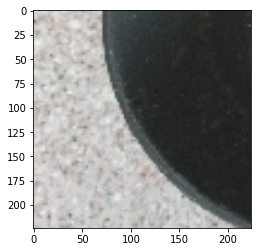

In [8]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

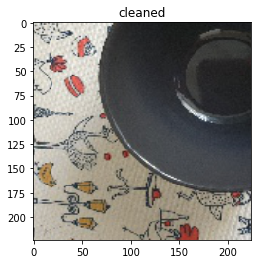

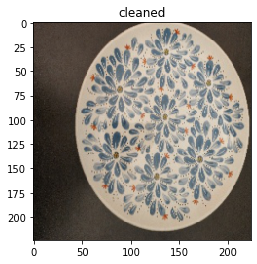

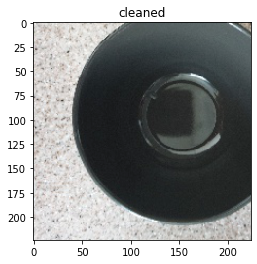

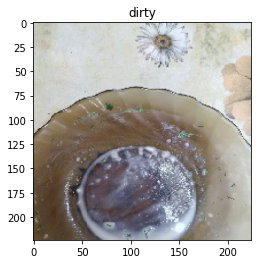

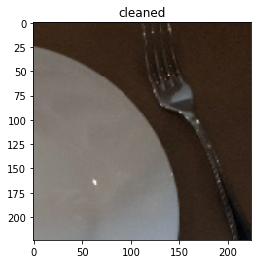

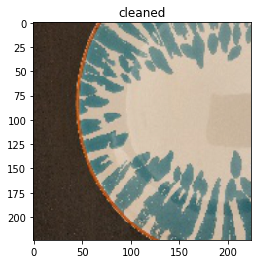

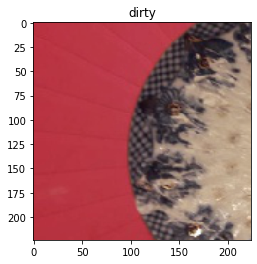

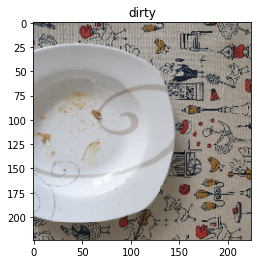

In [9]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [10]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [11]:
model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [12]:
train_model(model, loss, optimizer, scheduler, num_epochs=100);

Epoch 0/99:


/home/etagiev/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 4/4 [00:00<00:00,  9.26it/s]

train Loss: 0.7604 Acc: 0.4375



100%|██████████| 1/1 [00:00<00:00,  5.00it/s]

val Loss: 0.6419 Acc: 0.6250
Epoch 1/99:



100%|██████████| 4/4 [00:00<00:00, 13.72it/s]

train Loss: 0.6580 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  5.14it/s]

val Loss: 0.6070 Acc: 0.6250
Epoch 2/99:



100%|██████████| 4/4 [00:00<00:00, 13.60it/s]

train Loss: 0.6606 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  4.84it/s]

val Loss: 0.5756 Acc: 0.7500
Epoch 3/99:



100%|██████████| 4/4 [00:00<00:00, 14.68it/s]

train Loss: 0.6413 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  5.48it/s]

val Loss: 0.5755 Acc: 0.6250
Epoch 4/99:



100%|██████████| 4/4 [00:00<00:00, 14.61it/s]

train Loss: 0.6760 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  5.58it/s]

val Loss: 0.5060 Acc: 0.8750
Epoch 5/99:



100%|██████████| 4/4 [00:00<00:00, 13.38it/s]

train Loss: 0.5232 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  5.37it/s]

val Loss: 0.5135 Acc: 0.7500
Epoch 6/99:



100%|██████████| 4/4 [00:00<00:00, 14.72it/s]

train Loss: 0.5670 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  5.11it/s]

val Loss: 0.4959 Acc: 0.8750


Epoch 7/99:


100%|██████████| 4/4 [00:00<00:00, 14.18it/s]

train Loss: 0.5201 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  5.31it/s]

val Loss: 0.4923 Acc: 0.8750
Epoch 8/99:



100%|██████████| 4/4 [00:00<00:00, 14.30it/s]

train Loss: 0.4256 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  4.90it/s]

val Loss: 0.4886 Acc: 0.8750
Epoch 9/99:



100%|██████████| 4/4 [00:00<00:00, 14.02it/s]

train Loss: 0.5485 Acc: 0.7188



  0%|          | 0/1 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

In [ ]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths(test_dir, val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [ ]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

In [ ]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [ ]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [ ]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

In [ ]:
submission_df.to_csv('submission.csv')

In [ ]:
!rm -rf train val test